#### MPAS Vertical Cross Section plotting
- Read MPAS cells
- Cross section setup
- specify pressure levels 
- Read MPAS data 
- Vertical interpolation: interpolating the data from the model's vertical grid to a user-specified pressure levels
- Horizonatal interpolation:  use scipy.interpolate to compute cross-section interpolation     
- Create the figure

In [1]:
%matplotlib inline
 
import numpy as np
import xarray as xr

import matplotlib.collections as mplcollections
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.interpolate import griddata 

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# from https://github.com/Unidata/python-training/blob/master/pages/gallery/Observational_Data_Cross_Section.ipynb
# The vertical interpolation assumes a log-linear relationship.
def vertical_interpolate(vcoord_data, interp_var, interp_levels):
    """A function to interpolate sounding data from each station to
    every millibar. Assumes a log-linear relationship.

    Input
    -----
    vcoord_data : A 1D array of vertical level values (e.g., pressure from a radiosonde)
    interp_var : A 1D array of the variable to be interpolated to all pressure levels
    interp_levels : A 1D array containing veritcal levels to interpolate to

    Return
    ------
    interp_data : A 1D array that contains the interpolated variable on the interp_levels
    """

    # Make veritcal coordinate data and grid level log variables
    lnp = np.log(vcoord_data)
    lnp_intervals = np.log(interp_levels)

    # Use numpy to interpolate from observed levels to grid levels
    interp_data = np.interp(lnp_intervals[::-1], lnp[::-1], interp_var[::-1])[::-1]

    # Mask for missing data (generally only near the surface)
    mask_low = interp_levels > vcoord_data[0]
    mask_high = interp_levels < vcoord_data[-1]
    interp_data[mask_low] = interp_var[0]
    interp_data[mask_high] = interp_var[-1]

    return interp_data

#### Read MPAS Cells

In [3]:
flnm_ini = '/gpfs/fs1/p/mmm/c3we/MPAS-Release-5.2/CLIM/2010/x1.40962.init.nc'
ds_i = xr.open_dataset(flnm_ini)
ds_i = ds_i.squeeze()

# Convert to degrees from radians
ds_i["lonCell"] = np.degrees(ds_i.lonCell)
ds_i["latCell"] = np.degrees(ds_i.latCell)

# For Global tripcolor plot
# Add cyclic point before computing the triangulation
ds_i["lonCell"] = ((ds_i["lonCell"] + 180) % 360) - 180

# MPAS data point coordinates.
points = np.array([ds_i["lonCell"].values , ds_i["latCell"].values]).transpose()

triang = tri.Triangulation(ds_i.lonCell, ds_i.latCell)

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


#### Cross section setup

In [4]:
# # Create the start point and end point for the cross section
# Points at which to interpolate data.
lat_start, lon_start = (39,-120)
lat_end, lon_end = (39, -70)

# number of sample between start and end point
n_pt = 50
lat_1d = np.linspace(lat_start, lat_end, n_pt)
lon_1d = np.linspace(lon_start, lon_end, n_pt)

##### specify pressure levels 

In [5]:
# veritcal levels to interpolate to
p_1d = np.atleast_1d(np.arange(1000, 50, -100)) # hPa
n_p = len(p_1d)

##### Read MPAS data  

In [6]:
# the variable to be interpolated 
var_s = 'theta'

flnm = '/gpfs/fs1/p/mmm/c3we/MPAS-Release-5.2/CLIM/2010/restart.2011-04-24_00.00.00.nc'
ds = xr.open_dataset(flnm)
ds = ds.squeeze()

theta = ds[var_s] #theta(nCells, nVertLevels)
pressure_b = ds.pressure_base # pressure_base(nCells, nVertLevels)
pressure_p = ds.pressure_p    # pressure_p(nCells, nVertLevels)
 
pres = 0.01*(pressure_b + pressure_p)  #hPa


##### Vertical interpolation

In [8]:
n_cell = theta.shape[0]

var_2d = np.empty((n_p, n_cell))
for nc in range(n_cell):
    var_2d[:,nc] = vertical_interpolate(pres[nc].values, theta[nc].values, p_1d)    

##### Horizontal interpolation

In [9]:
hh_2d = np.empty((n_p, n_pt))

ct = 0
for nn in p_1d:
    # method='linear', 'cubic', 'nearest'
    hh_2d[ct, :] = griddata(points, var_2d[ct,:], (lon_1d, lat_1d), method='linear')
    ct = ct + 1    

##### Plotting

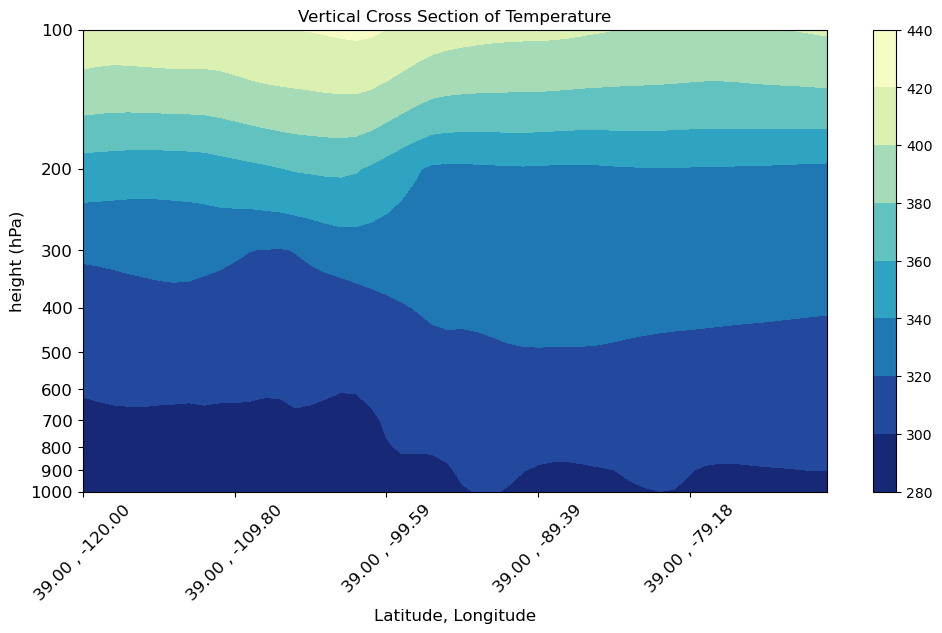

In [10]:
# Create the figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

# Make the contour plot
# contourf([X, Y,] Z, [levels], **kwargs)
t_cs = ax.contourf(np.arange(n_pt), np.arange(1000, 50, -100),hh_2d, cmap='YlGnBu_r')

# Add the color bar
plt.colorbar(t_cs, ax=ax)


# Set the x-ticks to use latitude and longitude labels.
x_labels = ["%.2f" % pair[1] + ' , '+  "%.2f" % pair[0] for pair in np.array([lon_1d, lat_1d]).transpose()]
ax.set_xticks(np.arange(n_pt)[::10])
ax.set_xticklabels(x_labels[::10], rotation=45, fontsize=12);

# Set the y-ticks to be height.
# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_ylim(p_1d.max(), p_1d.min())
ax.set_yticks(np.arange(1000, 50, -100))
ax.set_yticklabels(p_1d, fontsize=12)
#https://github.com/evans36/wrf-python-notebooks/blob/main/Vertical%20Cross%20Sections.ipynb


# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("height (hPa)", fontsize=12)

plt.title("Vertical Cross Section of Temperature");